# Facial Recognition Models for ASD Detection on AutismDataset

Training FaceNet, VGGFace2, and InsightFace models for autism spectrum disorder detection using the AutismDataset.

## Models to be trained:
1. **FaceNet** - Using InceptionResnetV1 with VGGFace2 pretrained weights
2. **VGGFace2** - ResNet50 backbone with face-specific modifications
3. **InsightFace** - Deep supervision model with BatchNorm and embeddings

These models are specifically designed for facial analysis and will be adapted for autism spectrum disorder detection.

# Data Preprocessing and Setup

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import math
import glob
from sklearn.model_selection import train_test_split

# Install facenet-pytorch if needed
try:
    from facenet_pytorch import InceptionResnetV1
    print("✓ facenet-pytorch is available")
except ImportError:
    print("⚠️ facenet-pytorch not found. Installing...")
    import subprocess
    subprocess.check_call(["pip", "install", "facenet-pytorch"])
    from facenet_pytorch import InceptionResnetV1

import timm

⚠️ facenet-pytorch not found. Installing...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 979.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.6 MB/s eta 0:00:00
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.2.2 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
bigframes 2.8.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.31.0, but you have google-cloud-bigquery 3.25.0 which is incompatible.
bigframes 2.8.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


## Facial Recognition Specific Transformations

Face-specific preprocessing that maintains facial features while providing augmentation suitable for facial recognition models.

In [2]:
# Face-specific transformations without augmentation to preserve facial features
face_train_transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Standard face recognition input size
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Face-specific normalization
])

face_val_test_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# VGGFace2 specific transforms (224x224)
vggface_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vggface_val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Loading and Preprocessing

Loading the AutismDataset with the mixed folder structure we identified earlier.

In [3]:
def create_dataset_from_folders():
    """
    Create dataset from AutismDataset folder structure
    Returns train, validation, and test splits
    
    Dataset structure:
    - train/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg)
    - test/: Mixed files (Autistic.X.jpg and Non_Autistic.X.jpg) 
    - valid/: Subdirectories (Autistic/ and Non_Autistic/)
    """
    base_path = '/kaggle/input/autism-image-data/AutismDataset'
    
    # Train and Test folders have mixed structure (files named by class)
    autistic_train = glob.glob(os.path.join(base_path, 'train', 'Autistic.*.jpg'))
    non_autistic_train = glob.glob(os.path.join(base_path, 'train', 'Non_Autistic.*.jpg'))
    
    autistic_test = glob.glob(os.path.join(base_path, 'test', 'Autistic.*.jpg'))
    non_autistic_test = glob.glob(os.path.join(base_path, 'test', 'Non_Autistic.*.jpg'))
    
    # Valid folder has subdirectory structure
    autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Autistic', '*.jpg'))
    non_autistic_valid = glob.glob(os.path.join(base_path, 'valid', 'Non_Autistic', '*.jpg'))
    
    # Create dataframes
    train_data = []
    train_data.extend([(path, 'Autistic') for path in autistic_train])
    train_data.extend([(path, 'Non_Autistic') for path in non_autistic_train])
    
    test_data = []
    test_data.extend([(path, 'Autistic') for path in autistic_test])
    test_data.extend([(path, 'Non_Autistic') for path in non_autistic_test])
    
    valid_data = []
    valid_data.extend([(path, 'Autistic') for path in autistic_valid])
    valid_data.extend([(path, 'Non_Autistic') for path in non_autistic_valid])
    
    # Convert to DataFrames
    train_df = pd.DataFrame(train_data, columns=['image_path', 'labels'])
    test_df = pd.DataFrame(test_data, columns=['image_path', 'labels'])
    valid_df = pd.DataFrame(valid_data, columns=['image_path', 'labels'])
    
    # Display dataset statistics
    print(f"Training samples: {len(train_df)}")
    print(f"  - Autistic: {len([x for x in train_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in train_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Validation samples: {len(valid_df)}")
    print(f"  - Autistic: {len([x for x in valid_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in valid_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Test samples: {len(test_df)}")
    print(f"  - Autistic: {len([x for x in test_data if x[1] == 'Autistic'])}")
    print(f"  - Non_Autistic: {len([x for x in test_data if x[1] == 'Non_Autistic'])}")
    
    print(f"Classes: {train_df['labels'].unique()}")
    
    return train_df, valid_df, test_df

# Create the dataset
train_df, valid_df, test_df = create_dataset_from_folders()

Training samples: 2540
  - Autistic: 1270
  - Non_Autistic: 1270
Validation samples: 100
  - Autistic: 50
  - Non_Autistic: 50
Test samples: 300
  - Autistic: 150
  - Non_Autistic: 150
Classes: ['Autistic' 'Non_Autistic']


## Custom Dataset Class for Facial Recognition

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class FacialRecognitionDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'image_path' and 'labels' columns
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe
        self.transform = transform
        
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['labels'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['labels'])
        
        self.image_paths = self.data['image_path'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Create a black placeholder image if file is missing/corrupted
            image = Image.new('RGB', (160, 160), color='black')  # Face-specific default size
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [5]:
# Create datasets with face-specific transforms
def create_face_datasets(train_df, val_df, test_df, transform_type='facenet'):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    if transform_type == 'facenet':
        train_transform = face_train_transform
        val_test_transform = face_val_test_transform
    elif transform_type == 'vggface':
        train_transform = vggface_train_transform
        val_test_transform = vggface_val_test_transform
    else:
        raise ValueError("transform_type must be 'facenet' or 'vggface'")

    train_dataset = FacialRecognitionDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True  
    )
    
    le = train_dataset.get_label_encoder()
    
    val_dataset = FacialRecognitionDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    test_dataset = FacialRecognitionDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

In [6]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Facial Recognition Model Architectures

## 1. FaceNet Model

In [7]:
def create_facenet_model(num_classes=2, pretrained=True, embedding_size=512):
    """Create FaceNet model using InceptionResnetV1"""
    
    class FaceNetClassifier(nn.Module):
        def __init__(self, num_classes, pretrained=True, embedding_size=512):
            super(FaceNetClassifier, self).__init__()
            # Load pretrained FaceNet model
            self.facenet = InceptionResnetV1(pretrained='vggface2' if pretrained else None, 
                                           classify=False, 
                                           num_classes=None)
            
            # Add classification head
            self.classifier = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(embedding_size, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )
            
        def forward(self, x):
            # Get embeddings from FaceNet
            embeddings = self.facenet(x)
            # Classify using our head
            output = self.classifier(embeddings)
            return output
    
    return FaceNetClassifier(num_classes, pretrained, embedding_size)

## 2. VGGFace2 Model

In [8]:
def create_vggface2_model(num_classes=2, pretrained=True):
    """Create VGGFace2 model using ResNet50 backbone"""
    # Use ResNet50 as backbone (commonly used for VGGFace2)
    model = models.resnet50(pretrained=pretrained)
    
    # Modify for face recognition
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

## 3. InsightFace Model

In [9]:
def create_insightface_model(num_classes=2, pretrained=True, embedding_size=512):
    """Create InsightFace-style model with deep supervision"""
    base_model = models.resnet50(pretrained=pretrained)
    
    class InsightFaceModel(nn.Module):
        def __init__(self, base_model, embedding_size, num_classes):
            super(InsightFaceModel, self).__init__()
            self.backbone = nn.Sequential(*list(base_model.children())[:-1])
            self.flatten = nn.Flatten()
            self.bn1 = nn.BatchNorm1d(2048)
            self.dropout = nn.Dropout(0.5)
            self.fc1 = nn.Linear(2048, embedding_size)
            self.bn2 = nn.BatchNorm1d(embedding_size)
            self.fc2 = nn.Linear(embedding_size, num_classes)
            
        def forward(self, x):
            x = self.backbone(x)
            x = self.flatten(x)
            x = self.bn1(x)
            x = self.dropout(x)
            embeddings = self.fc1(x)
            embeddings = self.bn2(embeddings)
            output = self.fc2(embeddings)
            return output
    
    return InsightFaceModel(base_model, embedding_size, num_classes)

# Training and Evaluation Framework

In [10]:
class FacialRecognitionTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda', use_margin_loss=False):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.use_margin_loss = use_margin_loss
        
        # Store label encoder from dataset
        try:
            self.label_encoder = train_loader.dataset.get_label_encoder()
        except:
            self.label_encoder = None
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="face_model"):
        """Train the facial recognition model"""
        
        # Loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        
        # Best model tracking
        best_val_acc = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 7
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        if self.use_margin_loss and phase == 'train':
                            # For ArcFace/CosFace models
                            outputs = self.model(inputs, labels)
                        else:
                            outputs = self.model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model
                if phase == 'val' and epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation accuracy: {best_val_acc:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation accuracy: {best_val_acc:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None):
        """Evaluate model on test set"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item()
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / len(test_loader)
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Get unique classes to understand the issue
        unique_labels = np.unique(all_labels)
        unique_preds = np.unique(all_preds)
        print(f"\nUnique labels in ground truth: {unique_labels}")
        print(f"Unique predictions: {unique_preds}")
        
        # Get class names from label encoder if available
        try:
            if hasattr(self, 'label_encoder') and self.label_encoder:
                class_names = self.label_encoder.classes_
            else:
                # Try to get from train_loader dataset
                class_names = self.train_loader.dataset.get_class_names()
        except:
            class_names = [f'Class_{i}' for i in range(max(max(unique_labels), max(unique_preds)) + 1)]
        
        print(f"Class names: {class_names}")
        
        # Detailed classification report
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, 
                                  labels=list(range(len(class_names))),
                                  target_names=class_names,
                                  zero_division=0))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        return test_acc, all_preds, all_labels
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# GPU Configuration and Data Validation

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

Using device: cuda
GPU: Tesla P100-PCIE-16GB
Memory: 15.89 GB


# Model Training Sections

## 1. FaceNet Model Training

In [12]:
# Create datasets for FaceNet (160x160 input)
print("Creating FaceNet datasets...")
facenet_train_dataset, facenet_val_dataset, facenet_test_dataset, facenet_label_encoder = create_face_datasets(
    train_df=train_df,
    val_df=valid_df, 
    test_df=test_df,
    transform_type='facenet'
)

# Create dataloaders
facenet_train_loader, facenet_val_loader, facenet_test_loader = create_dataloaders(
    facenet_train_dataset, facenet_val_dataset, facenet_test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"\nFaceNet Dataset Summary:")
print(f"Training samples: {len(facenet_train_dataset)}")
print(f"Validation samples: {len(facenet_val_dataset)}")
print(f"Test samples: {len(facenet_test_dataset)}")
print(f"Classes: {facenet_label_encoder.classes_}")

# Test data loading
print("\nTesting FaceNet data loading...")
try:
    facenet_batch = next(iter(facenet_train_loader))
    print(f"✓ FaceNet batch shape: {facenet_batch[0].shape}, Labels: {facenet_batch[1].shape}")
    print("✓ FaceNet data loading successful!\n")
except Exception as e:
    print(f"✗ FaceNet data loading failed: {e}")
    raise e

Creating FaceNet datasets...

FaceNet Dataset Summary:
Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']

Testing FaceNet data loading...
✓ FaceNet batch shape: torch.Size([32, 3, 160, 160]), Labels: torch.Size([32])
✓ FaceNet data loading successful!



Creating FaceNet model...


  0%|          | 0.00/107M [00:00<?, ?B/s]

Training FaceNet model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:10<00:00,  7.22it/s, Loss=0.6163, Acc=0.7480]


Train Loss: 0.6163 Acc: 0.7480


Val : 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, Loss=0.5367, Acc=0.7800]


Val Loss: 0.5367 Acc: 0.7800
✓ New best model saved with validation accuracy: 0.7800

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.20it/s, Loss=0.4467, Acc=0.8299]


Train Loss: 0.4467 Acc: 0.8299


Val : 100%|██████████| 4/4 [00:00<00:00,  8.46it/s, Loss=0.4699, Acc=0.8000]


Val Loss: 0.4699 Acc: 0.8000
✓ New best model saved with validation accuracy: 0.8000

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.24it/s, Loss=0.3008, Acc=0.8948]


Train Loss: 0.3008 Acc: 0.8948


Val : 100%|██████████| 4/4 [00:00<00:00,  7.73it/s, Loss=0.4093, Acc=0.8400]


Val Loss: 0.4093 Acc: 0.8400
✓ New best model saved with validation accuracy: 0.8400

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.31it/s, Loss=0.2163, Acc=0.9256]


Train Loss: 0.2163 Acc: 0.9256


Val : 100%|██████████| 4/4 [00:00<00:00,  8.10it/s, Loss=0.4815, Acc=0.8000]


Val Loss: 0.4815 Acc: 0.8000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.21it/s, Loss=0.1656, Acc=0.9450]


Train Loss: 0.1656 Acc: 0.9450


Val : 100%|██████████| 4/4 [00:00<00:00,  8.42it/s, Loss=0.4016, Acc=0.8500]


Val Loss: 0.4016 Acc: 0.8500
✓ New best model saved with validation accuracy: 0.8500

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.22it/s, Loss=0.0900, Acc=0.9735]


Train Loss: 0.0900 Acc: 0.9735


Val : 100%|██████████| 4/4 [00:00<00:00,  8.22it/s, Loss=0.4991, Acc=0.8300]


Val Loss: 0.4991 Acc: 0.8300

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.16it/s, Loss=0.0991, Acc=0.9680]


Train Loss: 0.0991 Acc: 0.9680


Val : 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, Loss=0.5400, Acc=0.8500]


Val Loss: 0.5400 Acc: 0.8500

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:10<00:00,  7.76it/s, Loss=0.0900, Acc=0.9715]


Train Loss: 0.0900 Acc: 0.9715


Val : 100%|██████████| 4/4 [00:00<00:00,  7.79it/s, Loss=0.5169, Acc=0.8500]


Val Loss: 0.5169 Acc: 0.8500

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.30it/s, Loss=0.0399, Acc=0.9893]


Train Loss: 0.0399 Acc: 0.9893


Val : 100%|██████████| 4/4 [00:00<00:00,  8.53it/s, Loss=0.5287, Acc=0.8500]


Val Loss: 0.5287 Acc: 0.8500

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.28it/s, Loss=0.0760, Acc=0.9759]


Train Loss: 0.0760 Acc: 0.9759


Val : 100%|██████████| 4/4 [00:00<00:00,  8.61it/s, Loss=0.3650, Acc=0.8700]


Val Loss: 0.3650 Acc: 0.8700
✓ New best model saved with validation accuracy: 0.8700

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.21it/s, Loss=0.0550, Acc=0.9842]


Train Loss: 0.0550 Acc: 0.9842


Val : 100%|██████████| 4/4 [00:00<00:00,  8.02it/s, Loss=0.5247, Acc=0.8300]


Val Loss: 0.5247 Acc: 0.8300

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.26it/s, Loss=0.0343, Acc=0.9901]


Train Loss: 0.0343 Acc: 0.9901


Val : 100%|██████████| 4/4 [00:00<00:00,  7.58it/s, Loss=0.5320, Acc=0.8600]


Val Loss: 0.5320 Acc: 0.8600

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.25it/s, Loss=0.0234, Acc=0.9953]


Train Loss: 0.0234 Acc: 0.9953


Val : 100%|██████████| 4/4 [00:00<00:00,  8.11it/s, Loss=0.7934, Acc=0.8100]


Val Loss: 0.7934 Acc: 0.8100

Epoch 14/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.20it/s, Loss=0.0525, Acc=0.9834]


Train Loss: 0.0525 Acc: 0.9834


Val : 100%|██████████| 4/4 [00:00<00:00,  7.50it/s, Loss=0.7068, Acc=0.7900]


Val Loss: 0.7068 Acc: 0.7900

Epoch 15/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.25it/s, Loss=0.0254, Acc=0.9913]


Train Loss: 0.0254 Acc: 0.9913


Val : 100%|██████████| 4/4 [00:00<00:00,  7.87it/s, Loss=0.7361, Acc=0.8300]


Val Loss: 0.7361 Acc: 0.8300

Epoch 16/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.25it/s, Loss=0.0144, Acc=0.9949]


Train Loss: 0.0144 Acc: 0.9949


Val : 100%|██████████| 4/4 [00:00<00:00,  8.03it/s, Loss=0.7600, Acc=0.7900]


Val Loss: 0.7600 Acc: 0.7900

Epoch 17/25
----------


Train : 100%|██████████| 79/79 [00:09<00:00,  8.30it/s, Loss=0.0103, Acc=0.9972]


Train Loss: 0.0103 Acc: 0.9972


Val : 100%|██████████| 4/4 [00:00<00:00,  8.61it/s, Loss=0.6394, Acc=0.8100]


Val Loss: 0.6394 Acc: 0.8100
Early stopping triggered after 17 epochs
Training complete in 2m 56s
Best validation accuracy: 0.8700
Evaluating FaceNet model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  8.70it/s]


Test Accuracy: 86.67%
Test Loss: 0.4163

Unique labels in ground truth: [0 1]
Unique predictions: [0 1]
Class names: ['Autistic' 'Non_Autistic']

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.89      0.84      0.86       150
Non_Autistic       0.85      0.89      0.87       150

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300


Confusion Matrix:
[[126  24]
 [ 16 134]]
Plotting FaceNet training history...


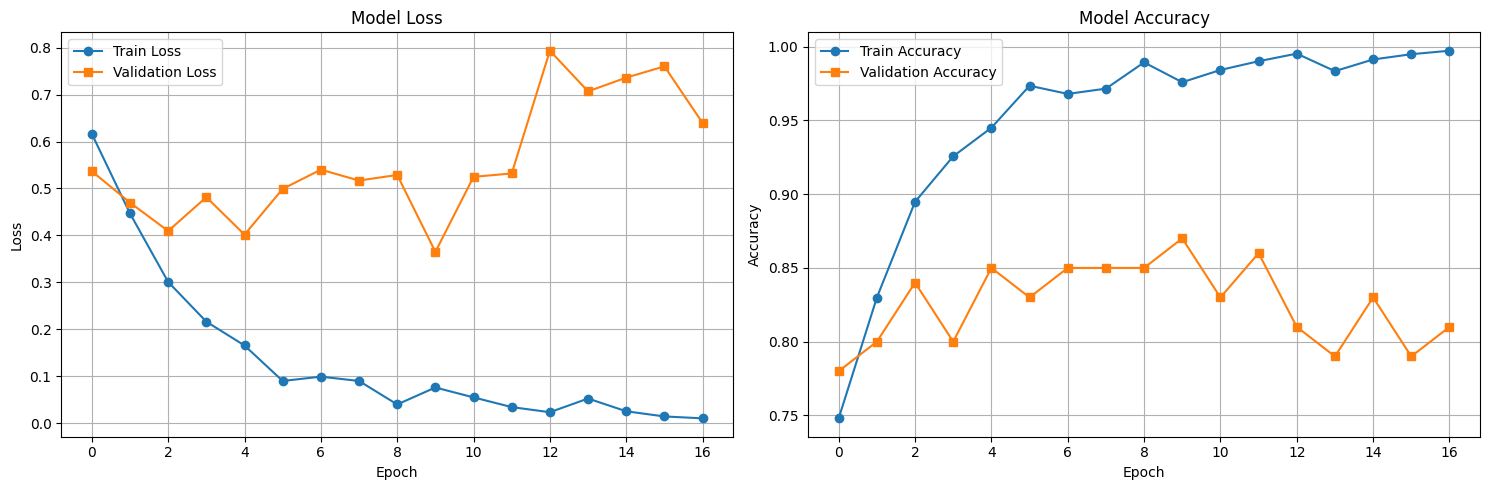

In [13]:
# Create and train FaceNet model
print("Creating FaceNet model...")
facenet_model = create_facenet_model(num_classes=2, pretrained=True)
facenet_trainer = FacialRecognitionTrainer(facenet_model, facenet_train_loader, facenet_val_loader, facenet_test_loader, device)

print("Training FaceNet model...")
trained_facenet = facenet_trainer.train_model(num_epochs=25, lr=0.0001, model_name="facenet_autism")

print("Evaluating FaceNet model...")
facenet_test_acc, facenet_preds, facenet_labels = facenet_trainer.evaluate_model()

print("Plotting FaceNet training history...")
facenet_trainer.plot_training_history()

## 2. VGGFace2 Model Training

In [14]:
# Create datasets for VGGFace2 (224x224 input)
print("Creating VGGFace2 datasets...")
vggface_train_dataset, vggface_val_dataset, vggface_test_dataset, vggface_label_encoder = create_face_datasets(
    train_df=train_df,
    val_df=valid_df, 
    test_df=test_df,
    transform_type='vggface'
)

# Create dataloaders
vggface_train_loader, vggface_val_loader, vggface_test_loader = create_dataloaders(
    vggface_train_dataset, vggface_val_dataset, vggface_test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"\nVGGFace2 Dataset Summary:")
print(f"Training samples: {len(vggface_train_dataset)}")
print(f"Validation samples: {len(vggface_val_dataset)}")
print(f"Test samples: {len(vggface_test_dataset)}")
print(f"Classes: {vggface_label_encoder.classes_}")

# Test data loading
print("\nTesting VGGFace2 data loading...")
try:
    vggface_batch = next(iter(vggface_train_loader))
    print(f"✓ VGGFace2 batch shape: {vggface_batch[0].shape}, Labels: {vggface_batch[1].shape}")
    print("✓ VGGFace2 data loading successful!\n")
except Exception as e:
    print(f"✗ VGGFace2 data loading failed: {e}")
    raise e

Creating VGGFace2 datasets...

VGGFace2 Dataset Summary:
Training samples: 2540
Validation samples: 100
Test samples: 300
Classes: ['Autistic' 'Non_Autistic']

Testing VGGFace2 data loading...
✓ VGGFace2 batch shape: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✓ VGGFace2 data loading successful!



Creating VGGFace2 model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


Training VGGFace2 model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.59it/s, Loss=0.4859, Acc=0.7670]


Train Loss: 0.4859 Acc: 0.7670


Val : 100%|██████████| 4/4 [00:00<00:00,  6.11it/s, Loss=0.4434, Acc=0.8000]


Val Loss: 0.4434 Acc: 0.8000
✓ New best model saved with validation accuracy: 0.8000

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.65it/s, Loss=0.1976, Acc=0.9276]


Train Loss: 0.1976 Acc: 0.9276


Val : 100%|██████████| 4/4 [00:00<00:00,  6.45it/s, Loss=0.3850, Acc=0.8700]


Val Loss: 0.3850 Acc: 0.8700
✓ New best model saved with validation accuracy: 0.8700

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.62it/s, Loss=0.0802, Acc=0.9775]


Train Loss: 0.0802 Acc: 0.9775


Val : 100%|██████████| 4/4 [00:00<00:00,  6.36it/s, Loss=0.5189, Acc=0.8100]


Val Loss: 0.5189 Acc: 0.8100

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0558, Acc=0.9814]


Train Loss: 0.0558 Acc: 0.9814


Val : 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Loss=0.4184, Acc=0.8400]


Val Loss: 0.4184 Acc: 0.8400

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0365, Acc=0.9881]


Train Loss: 0.0365 Acc: 0.9881


Val : 100%|██████████| 4/4 [00:00<00:00,  6.53it/s, Loss=0.4685, Acc=0.8300]


Val Loss: 0.4685 Acc: 0.8300

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0358, Acc=0.9877]


Train Loss: 0.0358 Acc: 0.9877


Val : 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, Loss=0.3351, Acc=0.8900]


Val Loss: 0.3351 Acc: 0.8900
✓ New best model saved with validation accuracy: 0.8900

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.59it/s, Loss=0.0181, Acc=0.9956]


Train Loss: 0.0181 Acc: 0.9956


Val : 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, Loss=0.4741, Acc=0.8400]


Val Loss: 0.4741 Acc: 0.8400

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0205, Acc=0.9937]


Train Loss: 0.0205 Acc: 0.9937


Val : 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, Loss=0.5101, Acc=0.8300]


Val Loss: 0.5101 Acc: 0.8300

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.62it/s, Loss=0.0420, Acc=0.9838]


Train Loss: 0.0420 Acc: 0.9838


Val : 100%|██████████| 4/4 [00:00<00:00,  6.38it/s, Loss=0.5150, Acc=0.8500]


Val Loss: 0.5150 Acc: 0.8500

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:13<00:00,  5.65it/s, Loss=0.0866, Acc=0.9688]


Train Loss: 0.0866 Acc: 0.9688


Val : 100%|██████████| 4/4 [00:00<00:00,  6.27it/s, Loss=0.5589, Acc=0.8000]


Val Loss: 0.5589 Acc: 0.8000

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0568, Acc=0.9802]


Train Loss: 0.0568 Acc: 0.9802


Val : 100%|██████████| 4/4 [00:00<00:00,  6.19it/s, Loss=0.5596, Acc=0.8600]


Val Loss: 0.5596 Acc: 0.8600

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.59it/s, Loss=0.0386, Acc=0.9885]


Train Loss: 0.0386 Acc: 0.9885


Val : 100%|██████████| 4/4 [00:00<00:00,  6.41it/s, Loss=0.7066, Acc=0.7900]


Val Loss: 0.7066 Acc: 0.7900

Epoch 13/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0406, Acc=0.9873]


Train Loss: 0.0406 Acc: 0.9873


Val : 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, Loss=0.5745, Acc=0.8100]


Val Loss: 0.5745 Acc: 0.8100
Early stopping triggered after 13 epochs
Training complete in 3m 12s
Best validation accuracy: 0.8900
Evaluating VGGFace2 model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.08it/s]


Test Accuracy: 86.67%
Test Loss: 0.3720

Unique labels in ground truth: [0 1]
Unique predictions: [0 1]
Class names: ['Autistic' 'Non_Autistic']

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.83      0.93      0.87       150
Non_Autistic       0.92      0.81      0.86       150

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300


Confusion Matrix:
[[139  11]
 [ 29 121]]
Plotting VGGFace2 training history...


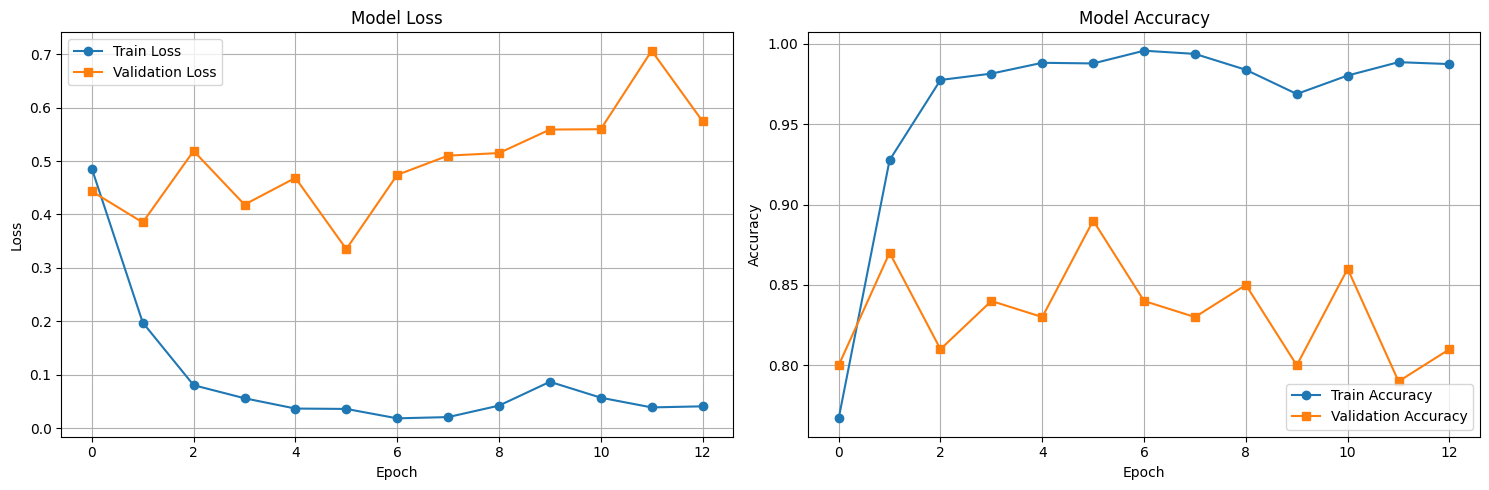

In [15]:
# Create and train VGGFace2 model
print("Creating VGGFace2 model...")
vggface2_model = create_vggface2_model(num_classes=2, pretrained=True)
vggface2_trainer = FacialRecognitionTrainer(vggface2_model, vggface_train_loader, vggface_val_loader, vggface_test_loader, device)

print("Training VGGFace2 model...")
trained_vggface2 = vggface2_trainer.train_model(num_epochs=25, lr=0.0001, model_name="vggface2_autism")

print("Evaluating VGGFace2 model...")
vggface2_test_acc, vggface2_preds, vggface2_labels = vggface2_trainer.evaluate_model()

print("Plotting VGGFace2 training history...")
vggface2_trainer.plot_training_history()

## 3. InsightFace Model Training

Creating InsightFace model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training InsightFace model...
Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.61it/s, Loss=0.5081, Acc=0.7666]


Train Loss: 0.5081 Acc: 0.7666


Val : 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Loss=0.5218, Acc=0.7600]


Val Loss: 0.5218 Acc: 0.7600
✓ New best model saved with validation accuracy: 0.7600

Epoch 2/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.1844, Acc=0.9312]


Train Loss: 0.1844 Acc: 0.9312


Val : 100%|██████████| 4/4 [00:00<00:00,  6.18it/s, Loss=0.5701, Acc=0.8200]


Val Loss: 0.5701 Acc: 0.8200
✓ New best model saved with validation accuracy: 0.8200

Epoch 3/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.62it/s, Loss=0.0847, Acc=0.9711]


Train Loss: 0.0847 Acc: 0.9711


Val : 100%|██████████| 4/4 [00:00<00:00,  6.15it/s, Loss=0.5919, Acc=0.8300]


Val Loss: 0.5919 Acc: 0.8300
✓ New best model saved with validation accuracy: 0.8300

Epoch 4/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0905, Acc=0.9664]


Train Loss: 0.0905 Acc: 0.9664


Val : 100%|██████████| 4/4 [00:00<00:00,  6.23it/s, Loss=0.7299, Acc=0.8000]


Val Loss: 0.7299 Acc: 0.8000

Epoch 5/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0635, Acc=0.9767]


Train Loss: 0.0635 Acc: 0.9767


Val : 100%|██████████| 4/4 [00:00<00:00,  6.14it/s, Loss=0.4563, Acc=0.8600]


Val Loss: 0.4563 Acc: 0.8600
✓ New best model saved with validation accuracy: 0.8600

Epoch 6/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0548, Acc=0.9778]


Train Loss: 0.0548 Acc: 0.9778


Val : 100%|██████████| 4/4 [00:00<00:00,  6.05it/s, Loss=1.0029, Acc=0.7800]


Val Loss: 1.0029 Acc: 0.7800

Epoch 7/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0709, Acc=0.9767]


Train Loss: 0.0709 Acc: 0.9767


Val : 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Loss=0.5196, Acc=0.8500]


Val Loss: 0.5196 Acc: 0.8500

Epoch 8/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.61it/s, Loss=0.0342, Acc=0.9873]


Train Loss: 0.0342 Acc: 0.9873


Val : 100%|██████████| 4/4 [00:00<00:00,  6.37it/s, Loss=0.6940, Acc=0.8400]


Val Loss: 0.6940 Acc: 0.8400

Epoch 9/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.62it/s, Loss=0.0402, Acc=0.9854]


Train Loss: 0.0402 Acc: 0.9854


Val : 100%|██████████| 4/4 [00:00<00:00,  6.21it/s, Loss=0.7158, Acc=0.8100]


Val Loss: 0.7158 Acc: 0.8100

Epoch 10/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.63it/s, Loss=0.0258, Acc=0.9901]


Train Loss: 0.0258 Acc: 0.9901


Val : 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, Loss=0.6107, Acc=0.8300]


Val Loss: 0.6107 Acc: 0.8300

Epoch 11/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.64it/s, Loss=0.0445, Acc=0.9838]


Train Loss: 0.0445 Acc: 0.9838


Val : 100%|██████████| 4/4 [00:00<00:00,  6.25it/s, Loss=0.7624, Acc=0.8100]


Val Loss: 0.7624 Acc: 0.8100

Epoch 12/25
----------


Train : 100%|██████████| 79/79 [00:14<00:00,  5.61it/s, Loss=0.0483, Acc=0.9818]


Train Loss: 0.0483 Acc: 0.9818


Val : 100%|██████████| 4/4 [00:00<00:00,  6.13it/s, Loss=0.9381, Acc=0.7800]


Val Loss: 0.9381 Acc: 0.7800
Early stopping triggered after 12 epochs
Training complete in 2m 57s
Best validation accuracy: 0.8600
Evaluating InsightFace model...
Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.20it/s]


Test Accuracy: 85.33%
Test Loss: 0.4688

Unique labels in ground truth: [0 1]
Unique predictions: [0 1]
Class names: ['Autistic' 'Non_Autistic']

Classification Report:
              precision    recall  f1-score   support

    Autistic       0.83      0.89      0.86       150
Non_Autistic       0.88      0.82      0.85       150

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300


Confusion Matrix:
[[133  17]
 [ 27 123]]
Plotting InsightFace training history...


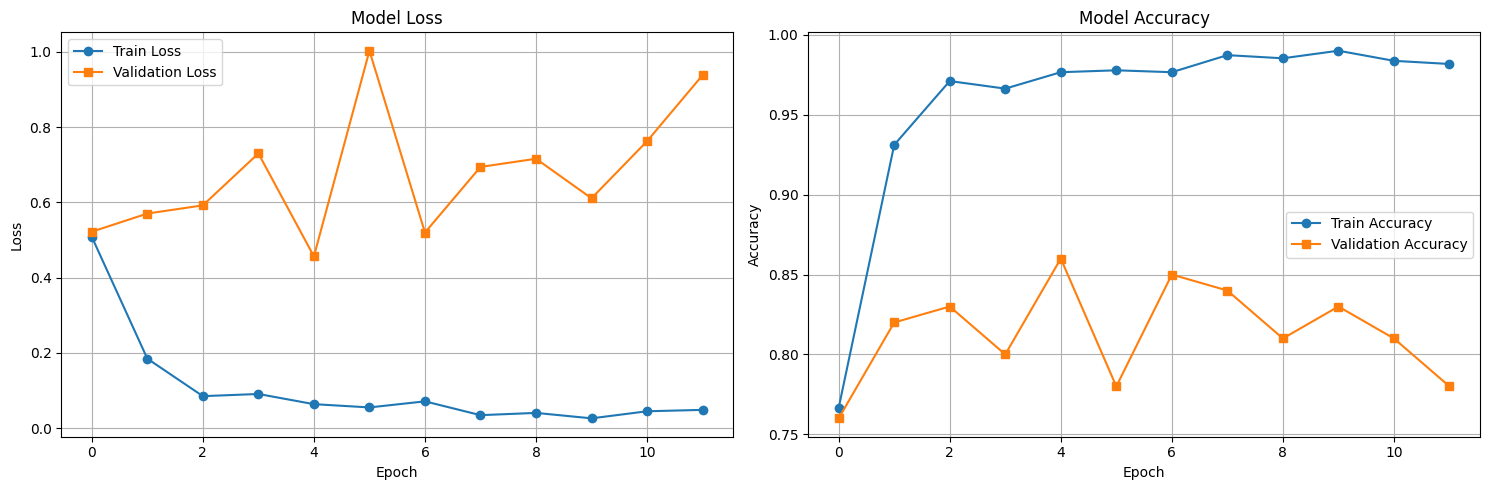

In [16]:
# Create and train InsightFace model
print("Creating InsightFace model...")
insightface_model = create_insightface_model(num_classes=2, pretrained=True, embedding_size=512)
insightface_trainer = FacialRecognitionTrainer(insightface_model, vggface_train_loader, vggface_val_loader, vggface_test_loader, device)

print("Training InsightFace model...")
trained_insightface = insightface_trainer.train_model(num_epochs=25, lr=0.0001, model_name="insightface_autism")

print("Evaluating InsightFace model...")
insightface_test_acc, insightface_preds, insightface_labels = insightface_trainer.evaluate_model()

print("Plotting InsightFace training history...")
insightface_trainer.plot_training_history()

# Results Summary and Model Comparison

AUTISM DATASET - FACIAL RECOGNITION MODELS PERFORMANCE SUMMARY
Model                Test Accuracy (%)
------------------------------------------------------------
FaceNet              86.67          
VGGFace2             86.67          
InsightFace          85.33          

TOP PERFORMING MODELS:
      Model  Test Accuracy
    FaceNet      86.666667
   VGGFace2      86.666667
InsightFace      85.333333


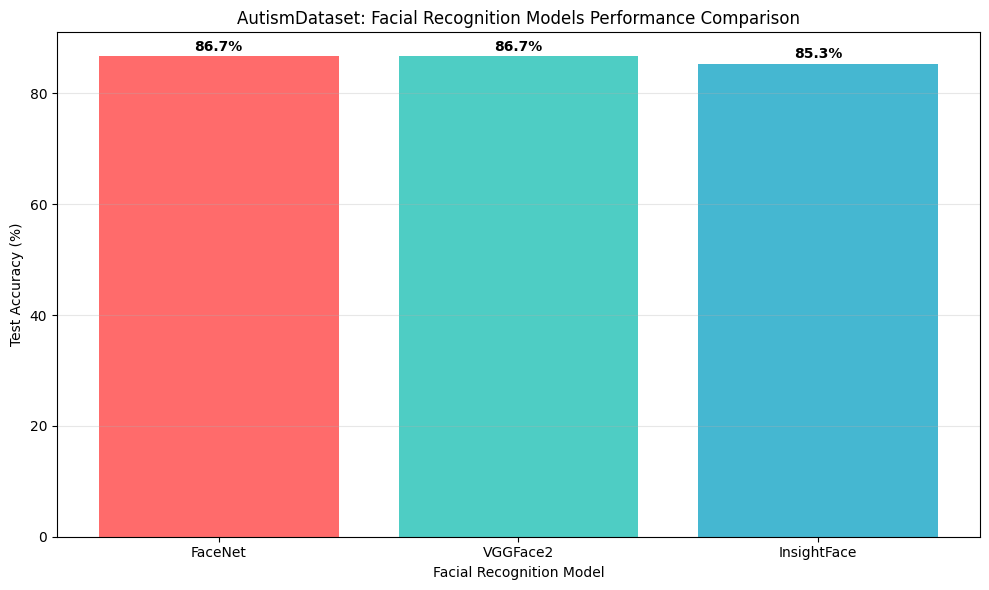


Facial recognition model training completed!
Results saved to 'autism_dataset_facial_recognition_results.csv'

MODEL CHARACTERISTICS:
FaceNet:
  - Architecture: InceptionResnetV1
  - Input Size: 160x160
  - Pretrained: VGGFace2 weights
  - Specialty: Face embeddings and verification

VGGFace2:
  - Architecture: ResNet50 backbone
  - Input Size: 224x224
  - Pretrained: ImageNet weights
  - Specialty: Large-scale face recognition

InsightFace:
  - Architecture: ResNet50 with deep supervision
  - Input Size: 224x224
  - Pretrained: ImageNet weights
  - Specialty: Face verification with margin-based learning


In [17]:
# Create a comprehensive results table for facial recognition models
results_data = []

# Collect all results
face_models_results = [
    ("FaceNet", "facenet_test_acc"),
    ("VGGFace2", "vggface2_test_acc"), 
    ("InsightFace", "insightface_test_acc")
]

print("=" * 60)
print("AUTISM DATASET - FACIAL RECOGNITION MODELS PERFORMANCE SUMMARY")
print("=" * 60)
print(f"{'Model':<20} {'Test Accuracy (%)':<15}")
print("-" * 60)

for model_name, acc_var in face_models_results:
    try:
        accuracy = eval(acc_var)
        print(f"{model_name:<20} {accuracy:<15.2f}")
        results_data.append({"Model": model_name, "Test Accuracy": accuracy})
    except NameError:
        print(f"{model_name:<20} {'Not Available':<15}")

# Create results DataFrame and save
if results_data:
    results_df = pd.DataFrame(results_data)
    results_df = results_df.sort_values('Test Accuracy', ascending=False)
    results_df.to_csv('autism_dataset_facial_recognition_results.csv', index=False)
    
    print("\n" + "=" * 60)
    print("TOP PERFORMING MODELS:")
    print("=" * 60)
    print(results_df.to_string(index=False))
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Model'], results_df['Test Accuracy'], 
                   color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    plt.xlabel('Facial Recognition Model')
    plt.ylabel('Test Accuracy (%)')
    plt.title('AutismDataset: Facial Recognition Models Performance Comparison')
    plt.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('autism_dataset_facial_recognition_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nFacial recognition model training completed!")
print("Results saved to 'autism_dataset_facial_recognition_results.csv'")

# Display model characteristics
print("\n" + "=" * 60)
print("MODEL CHARACTERISTICS:")
print("=" * 60)
print("FaceNet:")
print("  - Architecture: InceptionResnetV1")
print("  - Input Size: 160x160")
print("  - Pretrained: VGGFace2 weights")
print("  - Specialty: Face embeddings and verification")

print("\nVGGFace2:")
print("  - Architecture: ResNet50 backbone")
print("  - Input Size: 224x224") 
print("  - Pretrained: ImageNet weights")
print("  - Specialty: Large-scale face recognition")

print("\nInsightFace:")
print("  - Architecture: ResNet50 with deep supervision")
print("  - Input Size: 224x224")
print("  - Pretrained: ImageNet weights")
print("  - Specialty: Face verification with margin-based learning")